# Final Project for Module 1

Import packages that will be used throughout project

In [10]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

Upload all available data to Pandas dataframes

In [2]:
df_bom_movie_gross = pd.read_csv('data/bom.movie_gross.csv') # PRIMARY
df_imdb_name_basics = pd.read_csv('data/imdb.name.basics.csv')
df_imdb_title_akas = pd.read_csv('data/imdb.title.akas.csv')
df_imdb_title_basics = pd.read_csv('data/imdb.title.basics.csv') # PRIMARY
df_imdb_title_crew = pd.read_csv('data/imdb.title.crew.csv')
df_imdb_title_principals = pd.read_csv('data/imdb.title.principals.csv')
df_imdb_title_ratings = pd.read_csv('data/imdb.title.ratings.csv') # PRIMARY
df_rt_movie_info = pd.read_csv('data/rt.movie_info.tsv', delimiter = '\t')
df_rt_reviews = pd.read_csv('data/rt.reviews.tsv', delimiter = '\t', encoding= 'unicode_escape')
df_tmdb_movies = pd.read_csv('data/tmdb.movies.csv')
df_tn_movie_budgets = pd.read_csv('data/tn.movie_budgets.csv')

In [3]:
#print('-------------------- Data Available --------------------\n\n')

# print('bom_movie_gross:', df_bom_movie_gross.columns, '\n')
# print('imdb_name_basics:', df_imdb_name_basics.columns, '\n')
# print('imdb_title_akas:', df_imdb_title_akas.columns, '\n')
# print('imdb_title_basics:', df_imdb_title_basics.columns, '\n')
# print('imdb_title_crew:', df_imdb_title_crew.columns, '\n')
# print('imdb_title_principals:', df_imdb_title_principals.columns, '\n')
# print('imdb_title_ratings:', df_imdb_title_ratings.columns, '\n')
# print('rt_movie_info:', df_rt_movie_info.columns, '\n')
# print('rt_reviews:', df_rt_reviews.columns, '\n')
# print('tmdb_movies:', df_tmdb_movies.columns, '\n')
# print('tn_movie_budgets:', df_tn_movie_budgets.columns, '\n')

In [4]:
df_bom_movie_gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


## Possible avenues for investigation:

Possible correlations to investigate using *first three* databases:

- Gross vs. genre

- Gross vs. length
 
- Gross vs. year

- Gross vs. rating

- Rating vs. genre

- Rating vs. length

Considerations

- If there are really old movies, perhaps exclude them as they're less relevant to the market today

- Look at profit not just gross

In [5]:
# Cleaning BOM Movie Gross
# null values in Studio are fine for now
# null values in foreign gross will have to be addressed separately, perhaps 
# split into their own database since 1/3 of all values are null

df_bom_movie_gross

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010
...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,NaN,2018
3383,Edward II (2018 re-release),FM,4800.0,NaN,2018
3384,El Pacto,Sony,2500.0,NaN,2018
3385,The Swan,Synergetic,2400.0,NaN,2018


In [6]:
df_tn_movie_budgets

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


In [33]:
#Combine two movie budget dataframes

q = '''
SELECT * 
FROM df_tn_movie_budgets tn
LEFT JOIN df_bom_movie_gross bom
ON tn.movie == bom.title
WHERE bom.domestic_gross > 0
;'''

finances = pysqldf(q)
finances

#next, are the 'gross' values equal after rounding?

pandas.core.frame.DataFrame

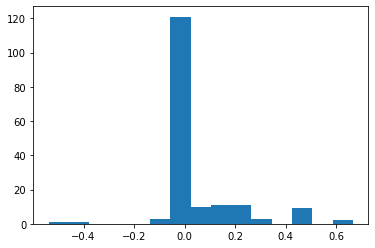

In [114]:
temp = pd.DataFrame()

temp['a'] = finances['domestic_gross'].iloc[:,0]
temp['b'] = [int(x.replace('$','').replace(',','')) for x in temp['a']]
temp['c'] = [float(round(x, -5)) for x in temp['b']]

temp['bom'] = finances['domestic_gross'].iloc[:,1]

temp['eq'] = temp['c'] == temp['bom']


#temp['eq'].nunique()


temp['eq'].value_counts()



non_equals = temp.loc[temp['eq'] == False]

non_equals = non_equals.drop(axis=1, labels=['a','b', 'eq'])/10**5
non_equals.columns = ['The Numbers (DG)', 'Box Office Mojo (DG)']
a = [int(x) for x in non_equals['The Numbers (DG)']]
b = [int(x) for x in non_equals['Box Office Mojo (DG)']]

non_equals = pd.DataFrame({'The Numbers (DG)':a, 'Box Office Mojo (DG)':b})

non_equals['Is "TN" >= "BOM"'] = non_equals.iloc[:,0] >= non_equals.iloc[:,1]

non_equals.iloc[:,2].value_counts()

non_equals['% diff'] = (non_equals.iloc[:,0] - non_equals.iloc[:,1]) / non_equals.iloc[:,0]


plt.hist(non_equals['% diff'].loc[(non_equals['% diff']> -0.8) & (non_equals['% diff'] < 0.8)], bins=15)
plt.figsize = (20,20)
plt.show()